In [2]:
# import zone
from vision_models_playground.datasets.datasets import get_voc_detection_dataset_yolo_aug

import cv2
import numpy as np
import PIL

In [3]:
# Get the dataset
voc_train, voc_test = get_voc_detection_dataset_yolo_aug(root='./../data')

In [4]:
voc_train.normal_len

5717

In [8]:
# Grab a sample
image, target = voc_train[voc_train.normal_len]

In [9]:
image.shape

torch.Size([3, 448, 448])

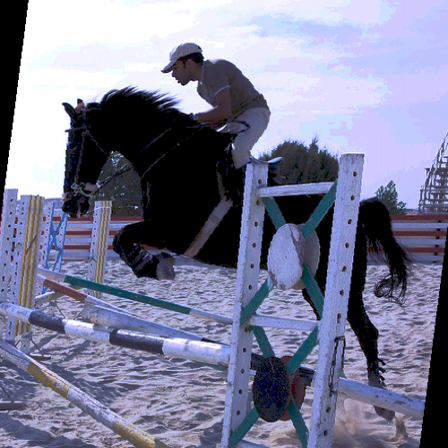

In [10]:
# Convert the image tensor to PIL image
pil_image = PIL.Image.fromarray((image.permute(1, 2, 0) * 255).numpy().astype(np.uint8))
pil_image

In [11]:
target.shape

torch.Size([7, 7, 30])

In [12]:
# filter only the targets with objects by looking at the 5th and 10th column
mask = (target[:, :, 4] > 0.5) | (target[:, :, 9] > 0.5)
# get the row and column indices of the targets with objects
row_index, col_index = np.where(mask)
pairs = list(zip(row_index, col_index))
print(pairs)

[(1, 3), (4, 3)]


In [13]:
# get the class labels of the targets with objects
class_labels_one_hot = target[row_index, col_index, 10:]
print(class_labels_one_hot)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.]])


In [14]:
# Reverse one hot encoding
class_labels_id = np.argmax(class_labels_one_hot, axis=1).tolist()
print(class_labels_id)

[14, 12]


In [15]:
# Get from index to class name mapping
class_to_idx_map = voc_train.class_map
idx_to_class_map = {v: k for k, v in class_to_idx_map.items()}

class_names = [idx_to_class_map[class_id] for class_id in class_labels_id]
print(class_names)

['person', 'horse']


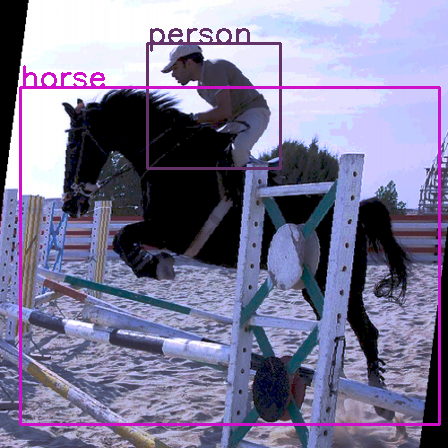

In [16]:
# Print the image with bounding boxes
image_edited = np.array(pil_image)

for (row, col), class_name in zip(pairs, class_names):
    # Assign a random color to the bounding box
    color = np.random.randint(0, 255, size=3).tolist()

    # Determine the cell position
    cell_size_x, cell_size_y = voc_train.cell_size

    x_cell = col * cell_size_x / image_edited.shape[0]
    y_cell = row * cell_size_y / image_edited.shape[1]

    # Get the bounding box coordinates
    x, y, w, h = target[row, col, :4].tolist()

    # Convert the coordinates to image coordinates
    center_x = (x + x_cell) * image_edited.shape[0]
    center_y = (y + y_cell) * image_edited.shape[1]
    w = (w * image_edited.shape[0])
    h = (h * image_edited.shape[1])

    x_min = int(center_x - w / 2)
    y_min = int(center_y - h / 2)
    x_max = int(center_x + w / 2)
    y_max = int(center_y + h / 2)

    # Draw the bounding box
    cv2.rectangle(image_edited, (x_min, y_min), (x_max, y_max), color, 2)

    # Draw the class name
    cv2.putText(image_edited, class_name, (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

# Convert it back to PIL image
image_edited = PIL.Image.fromarray(image_edited)
image_edited